In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import zeus
from modules import init_cosmology, init_sample, PNGModel, Posterior, read_mocks

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
bins: [  3   5   7   9  11  13  15  17  19  26  48  96 192 384]
will create windows


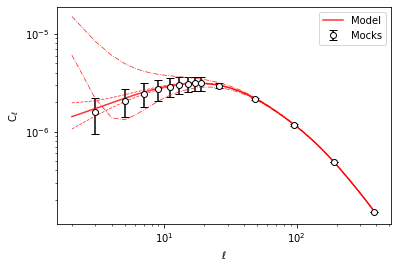

In [2]:
# --- theory
cosmo = init_cosmology()
z, b, dNdz = init_sample()
model = PNGModel(cosmo, has_fnl=True, has_rsd=True)
model.add_tracer(z, b, dNdz)

# --- 'Data'
x, y, invcov, cov = read_mocks('full', return_cov=True)

# plot
plt.errorbar(x, y, yerr=np.diag(cov)**0.5, 
             ls='none', color='k', marker='o', mfc='w', capsize=4, 
             label='Mocks')

x_ = np.arange(2, 400)

plt.plot(x_, model(x_), 'r-', label='Model', alpha=0.8)
plt.plot(x_, model(x_, fnl=10.), 'r--', alpha=0.8, lw=0.8)
plt.plot(x_, model(x_, fnl=-10.), 'r--', alpha=0.8, lw=0.8)
plt.plot(x_, model(x_, fnl=100.), 'r-.', alpha=0.8, lw=0.8)
plt.plot(x_, model(x_, fnl=-100.), 'r-.', alpha=0.8, lw=0.8)

plt.loglog()
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel('C$_{\ell}$')
plt.savefig('mocks_model.png', dpi=300, bbox_inches='tight')

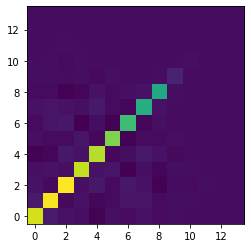

In [3]:
plt.imshow(cov, origin='lower')

In [4]:
lg = Posterior(model)

In [5]:
for fNL in [-999, -500, -100, -10, 0, 10, 100, 500, 999]:
    print(fNL, lg.logpost(fNL, y, invcov, x))

will update windows
-999 -133179.91655167053
-500 -6779.895085240018
-100 -22.159791313913097
-10 -18.585494842775088
0 -18.59129628664483
10 -19.014081274435927
100 -89.0530603872647
500 -14703.137764757632
999 -196266.68771230048


In [6]:
np.random.seed(42)

ndim = 1       # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10  # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 1000  # Number of steps/iterations.

start = 10. * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.
print(f'initial guess: {start}')

sampler = zeus.EnsembleSampler(nwalkers, ndim, lg.logpost, args=[y, invcov, x], maxiter=100000)
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress :   0%|          | 0/1000 [00:00<?, ?it/s]

initial guess: [[ 4.96714153]
 [-1.38264301]
 [ 6.47688538]
 [15.23029856]
 [-2.34153375]
 [-2.34136957]
 [15.79212816]
 [ 7.67434729]
 [-4.69474386]
 [ 5.42560044]]


Sampling progress : 100%|██████████| 1000/1000 [08:25<00:00,  1.98it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 1
Number of Walkers: 10
Number of Tuning Generations: 64
Scale Factor: 2.139041
Mean Integrated Autocorrelation Time: 1.4
Effective Sample Size: 7155.77
Number of Log Probability Evaluations: 81954
Effective Samples per Log Probability Evaluation: 0.087314


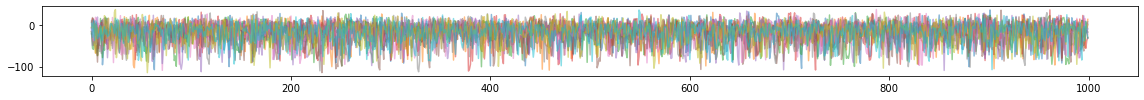

In [7]:
plt.figure(figsize=(16, 1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# flatten the chains, thin them by a factor of 15, 
# and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=20, thin=5)

In [9]:
np.save('chains.npy', chain)  # 

In [11]:
bins = np.arange(-1000, 1000., 3.8*np.std(chain)/(chain.size)**(1./3)) #
bins[:10]

array([-1000.        ,  -992.43724517,  -984.87449034,  -977.31173551,
        -969.74898068,  -962.18622585,  -954.62347101,  -947.06071618,
        -939.49796135,  -931.93520652])

(-200.0, 200.0)

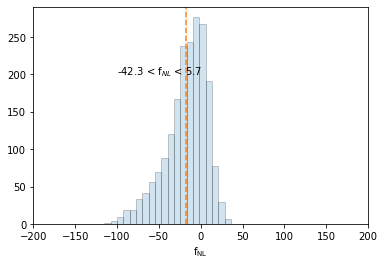

In [13]:
_= plt.hist(chain,
            bins=bins, 
            color='C0', alpha=0.2, edgecolor='k')
plt.axvline(np.mean(chain), color='C1', ls='--')
fmin, fmax = np.percentile(chain, [15.7, 84.3])
plt.text(-100, 200, fr"{fmin:.1f} < f$_{'{NL}'}$ < {fmax:.1f}")

plt.xlabel(r'f$_{\rm NL}$')
plt.xlim(-200, 200)
# plt.savefig('fnl.png', dpi=300, bbox_inches='tight')

In [14]:
np.mean(chain)

-17.56812161234904

In [15]:
np.percentile(chain, [15.7, 84.3])

array([-42.30893137,   5.66338158])